# Capstone Project - The Battle of the Neighborhoods (Week 2)
## Applied Data Science Capstone by IBM/Coursera 
### By Nishant Vemulakonda

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

A retail company wants to set up supermarket stores in Hyderabad city. But it is not exactly sure about which Neighbourhood(s) to open the store(s) in.
The chosen locations should ideally have a considerable population so that there is more store footfall & near to work centres/residential districts for easier access to a large number of citizens.
The Operations Head has sought your help to solve the company’s business problem.
There are 2 business questions that need to be answered here.
1.	Which part (area) of the city should the company open the supermarket first.
 
2.	Which Neighbourhood(s) would be ideal in that part (as in point 1) setting up such a supermarket in the city.

When we consider the business problem, we can create a map and information chart where the real estate prices are placed on Hyderabad and each area is clustered according to the venue density.


## Data Description:<a name="data"></a>

In order to solve the business problem, I have decided to use the following data as listed below, which includes the <b>Foursquare Location data API</b>.

•	Geographical co-ordinates data of Neighborhoods in Hyderabad city and zip codes from GitHub repository.
Source : https://github.com/sanand0/pincode/blob/master/data/IN.csv

Use:
This data would be used for getting zip codes, for Neighbourhood mapping and helps to display points on Folium based maps.

•	<b>Venue data</b> for each Neighbourhood in the city using <b>Foursquare API</b>. I included venues within a 1000 metre radius from each neighbourhood centre.

Use:
The data helps us to identify similar Neighbourhoods using venues.
Also helps in clustering algorithm.

•	<b>Geo-Json data</b> for GHMC (Hyderabad Municipality) for Choropleth Maps (to show real estate prices & population spread).

Use:
Mapping Neighbourhoods on Folium Map. Generating centres for each Neighbourhood using geo co-ordinates.
The data helps us to show real estate prices & population spread on Choropleth/Folium Maps.

•	Average House prices (per square feet) for each Neighbourhood in Hyderabad city.

Source: https://www.makaan.com/price-trends/property-rates-for-buy-in-hyderabad

Use:
The data helps us to show real estate prices on Choropleth Maps and to identify potential Neighbourhoods where stores can be opened.


### Importing Libraries

In [1]:
import pandas as pd # Data analsysis
import numpy as np
from bs4 import BeautifulSoup as bs # For Web scraping

from geopy.geocoders import Nominatim # convert address into latitude & longitude
import requests # To Handle web requests
import json

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# !pip install folium
import folium as Folium # Creats Folium Maps

# k-means for clustering
from sklearn.cluster import KMeans

print('Libraries imported')

Libraries imported


## Methodology:<a name="methodology"></a>

### PART 1: Extracting required data
#### Web scraping to get Neighborhood data and build a pandas dataframe

In [3]:
#Since there are multiple pages with data, we will build urls and get the compete data
page_list = ["?page=" + str(i) for i in range(1,20)]
page_list

#Lists to store locality & persft price data
locality_data = []
avg_price = []

# Building URL
for page in page_list:
    URL = "https://www.makaan.com/price-trends/property-rates-for-buy-in-hyderabad"+ page
    source = requests.get(URL, headers={"User-Agent":"Mozilla/5.0"}).text
    soup11 = bs(source, 'lxml')
    property_rates_tbl = soup11.find_all('table')[0]
    locality =  [str(data.text) for data in property_rates_tbl.find_all('td')][::6],
    Avg_price = [str(data.text).split("/")[0].strip() for data in property_rates_tbl.find_all('td')][2::6]
    
    locality_data.extend(locality)
    avg_price.extend(Avg_price)

In [4]:
locality_data_dict = []
for l in range(len(locality_data)):
    for i,j in zip(locality_data[l],avg_price):
        locality_data_dict.append([i,j])


In [5]:
locality_data_dict[:10]

[['Kadthal', '-'],
 ['Tellapur', '38,724.88'],
 ['Tukkuguda', '3,301.23'],
 ['Gachibowli', '36,311.39'],
 ['Adibatla', '17,36.87'],
 ['Shadnagar', '1,600'],
 ['Maheshwaram', '-'],
 ['Rajendra Nagar', '6,239.29'],
 ['Kothur', '3,500'],
 ['Kondapur', '7,274.54']]

In [ ]:
#Creating pandas dataframe from the list
data = pd.DataFrame.from_dict(locality_data_dict)

data.columns = ['Locality','Avg_Price']

### Reading data from file

In [2]:
data = pd.read_csv("Locality_data.csv")
data.drop("Unnamed: 0", axis=1,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 2 columns):
Locality     1140 non-null object
Avg_Price    1140 non-null object
dtypes: object(2)
memory usage: 17.9+ KB


#### Data Cleaning & standardizing

In [3]:
Hyd_locality_data = data[~(data.Avg_Price == "-")].reset_index(drop=True)
Hyd_locality_data.Avg_Price = Hyd_locality_data.Avg_Price.str.replace(",","")
Hyd_locality_data.Avg_Price = pd.to_numeric(Hyd_locality_data.Avg_Price)

Hyd_locality_data.drop_duplicates(subset='Locality',inplace=True) # Removing duplicates

Hyd_locality_data.info()
Hyd_locality_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 0 to 740
Data columns (total 2 columns):
Locality     735 non-null object
Avg_Price    735 non-null float64
dtypes: float64(1), object(1)
memory usage: 17.2+ KB


,Locality,Avg_Price
0,Tellapur,38724.88
1,Tukkuguda,3301.23
2,Gachibowli,36311.39
3,Adibatla,1736.87
4,Shadnagar,1600.00


### Geo-json file with data 150 Hyderabad Neighborhood coordinates (boundaries)

In [4]:
Hyd_geojson = "Hyd_ghmc_geojson.json"

with open(Hyd_geojson) as json_data:
    Hyd_geo_data = json.load(json_data)
    
def Geojson_map_style(feature):
    return { 'color': 'blue', 'fill': True }

#### Hyderabad Coordinates using geopy

In [5]:
address = "Hyderabad, IN"

geolocator = Nominatim(user_agent="foursquare")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hyderabad City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hyderabad City are 17.3616079, 78.4746286.


### Choropleth Map showing distribution of House prices by Neighborhood

In [6]:
Hyd_Map = Folium.Map(location=[latitude, longitude], zoom_start=11)

Hyd_Map.choropleth(
    geo_data=Hyd_geojson,
    data=Hyd_locality_data,
    columns=['Locality','Avg_Price'],
    key_on= 'properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.6, 
    line_opacity=0.3
    )
Hyd_Map

### Distribution of Avg Prices per square feet (EDA)

In [7]:
Hyd_locality_data.describe()

,Avg_Price
count,735.000000
mean,8457.119034
std,10817.843494
min,513.100000
25%,3327.310000
50%,4495.220000
75%,7274.540000
max,45910.380000


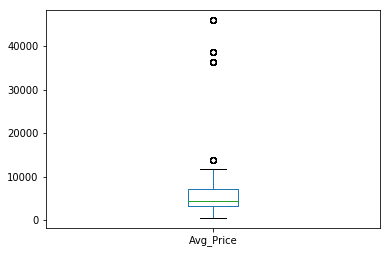

In [8]:
Hyd_locality_data.plot(kind='box')
plt.show()

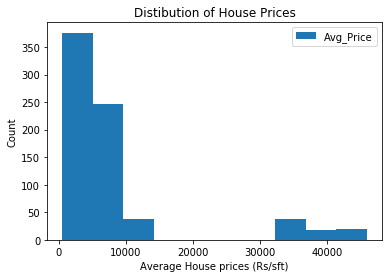

In [55]:
Hyd_locality_data.plot(kind='hist',bins=10)
plt.title("Distibution of House Prices")
plt.xlabel("Average House prices (Rs/sft)")
plt.ylabel("Count")
plt.show()

#### Visualising Neighborhoods on Map

In [9]:
Hyd_Map = Folium.Map(location=[latitude,longitude], zoom_start=11)
Folium.GeoJson(Hyd_geo_data, style_function=Geojson_map_style, name='Hyd_ghmc_geojson').add_to(Hyd_Map)
Hyd_Map

### PART 1B. Calculating centre coordinates for each Neighborhood  & Visualising
#### Creating Neighborhood data using geojson data

In [10]:
# define dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
Neighborhood_data = pd.DataFrame(columns=column_names)
Neighborhood_data.head()

,Neighborhood,Latitude,Longitude


In [11]:
# Getting Neighborhood names from geojson
Neighborhood_names =[]
for data in Hyd_geo_data["features"]:
    neighborhood = data['properties']['name']
    Neighborhood_names.append(neighborhood)

In [12]:
Neighborhood_names[:5]

['Khairatabad Road',
 'Gachibowli',
 'Rajendra Nagar',
 'Jubilee Hills',
 'Nacharam']

### Center co-ordinates (latitude/longitude) for each Neighborhood

In [13]:
centers=[]
for n in range(len(Hyd_geo_data["features"])):
    longs = [i[0] for i in Hyd_geo_data["features"][n]['geometry']['coordinates'][0]]
    lats  = [i[1] for i in Hyd_geo_data["features"][n]['geometry']['coordinates'][0]]
    center = np.array(lats).mean(axis=0),np.array(longs).mean(axis=0)
    
    centers.append(center)
    
center_longs  = [ (c[0][0]+c[1][0])/2 if str(type(c[0])) == "<class 'numpy.ndarray'>" else c[1] for c in centers]
center_lats   = [ (c[0][1]+c[1][1])/2 if str(type(c[0])) == "<class 'numpy.ndarray'>" else c[0] for c in centers]

#### Visualising Neighborhoods and Neighborhood centers

In [14]:
Hyd_Map = Folium.Map(location=[17.3850, 78.4867], zoom_start=11)
Folium.GeoJson(Hyd_geo_data, style_function=Geojson_map_style, name='Hyd_ghmc_wards2').add_to(Hyd_Map)

for lat,long in zip(center_lats,center_longs):
    Folium.CircleMarker([lat,long], color='red', fill_opacity= 0.05, fill=True, radius=2).add_to(Hyd_Map)


Hyd_Map    

In [15]:
# Creating Pandas Dataframe
Neighborhood_data['Neighborhood'] = Neighborhood_names
Neighborhood_data['Latitude'] = center_lats
Neighborhood_data['Longitude'] = center_longs
Neighborhood_data.head(10)

,Neighborhood,Latitude,Longitude
0,Khairatabad Road,17.422243,78.467054
1,Gachibowli,17.438649,78.346610
2,Rajendra Nagar,17.335965,78.410689
3,Jubilee Hills,17.426672,78.412085
4,Nacharam,17.427800,78.553945
5,Mailardevpally,17.313355,78.427124
6,Macha Bolarum,17.521572,78.546473
7,Kapra,17.495956,78.556134
8,Neredmet,17.470202,78.532658
9,AS Rao Nagar,17.480058,78.568694


In [16]:
# Combining Avg_price & coordinates data
Neighborhood_data_full = pd.merge(Neighborhood_data,Hyd_locality_data, how='inner', right_on=['Locality'], left_on=['Neighborhood'])
Neighborhood_data_full.drop('Locality',axis=1,inplace=True)
Neighborhood_data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 89
Data columns (total 4 columns):
Neighborhood    90 non-null object
Latitude        90 non-null float64
Longitude       90 non-null float64
Avg_Price       90 non-null float64
dtypes: float64(3), object(1)
memory usage: 3.5+ KB


### Importing Neighborhood  &  Zipcodes

In [19]:
# filepath = "E:/LEARNING/MATERIALS/R_Workspace/datafiles/IN/IN.txt"
df = pd.read_csv("IN.txt", sep='\t', header=None)

#removing unwanted columns
df.drop([0,3,4,6,7,8,9,10,11], axis = 1, inplace=True)
df.head()

,1,2,5
0,744101,Marine Jetty,South Andaman
1,744101,Port Blair,South Andaman
2,744101,N.S.Building,South Andaman
3,744102,Haddo,South Andaman
4,744102,Chatham,South Andaman


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154809 entries, 0 to 154808
Data columns (total 3 columns):
1    154809 non-null int64
2    154809 non-null object
5    154809 non-null object
dtypes: int64(1), object(2)
memory usage: 3.5+ MB


In [21]:
df.columns = ['Zipcode','Neighborhood','District']
df.head()

,Zipcode,Neighborhood,District
0,744101,Marine Jetty,South Andaman
1,744101,Port Blair,South Andaman
2,744101,N.S.Building,South Andaman
3,744102,Haddo,South Andaman
4,744102,Chatham,South Andaman


### Extracting Neighborhoods in Hyderabad only

In [22]:
Hyd_Neighborhood_zipcodes = df[df.District.isin(['Hyderabad','K.V.Rangareddy'])].reset_index(drop=True)

# dropping missing data
Hyd_Neighborhood_zipcodes['Neighborhood'].dropna()

#Removing duplicates
Hyd_Neighborhood_zipcodes.drop_duplicates(subset=['Zipcode','Neighborhood'])
Hyd_Neighborhood_zipcodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 3 columns):
Zipcode         572 non-null int64
Neighborhood    572 non-null object
District        572 non-null object
dtypes: int64(1), object(2)
memory usage: 13.5+ KB


### Data cleaning & Standardizing

In [23]:
#stripping extra blanks
Hyd_Neighborhood_zipcodes.Neighborhood = Hyd_Neighborhood_zipcodes.Neighborhood.str.strip()

#Cleaning Neighborhood names
Hyd_Neighborhood_zipcodes['Neighborhood_tmp'] = Hyd_Neighborhood_zipcodes.Neighborhood

Hyd_Neighborhood_zipcodes.Neighborhood_tmp = [i.split(" ")[0].strip() if i.find('K.V.Rangareddy') > 0 else i for i in Hyd_Neighborhood_zipcodes.Neighborhood_tmp]
Hyd_Neighborhood_zipcodes.Neighborhood_tmp = [j.replace('(Hyderabad)',"") if j.find('Hyderabad') > 0 else j for j in Hyd_Neighborhood_zipcodes.Neighborhood_tmp]
Hyd_Neighborhood_zipcodes.Neighborhood_tmp = [i.strip() for i in Hyd_Neighborhood_zipcodes.Neighborhood_tmp]

Hyd_Neighborhood_zipcodes.drop(['District'], axis=1, inplace=True)


Hyd_Neighborhood_zipcodes.info()
Hyd_Neighborhood_zipcodes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 3 columns):
Zipcode             572 non-null int64
Neighborhood        572 non-null object
Neighborhood_tmp    572 non-null object
dtypes: int64(1), object(2)
memory usage: 13.5+ KB


,Zipcode,Neighborhood,Neighborhood_tmp
0,500001,Hyderabad G.P.O.,Hyderabad G.P.O.
1,500001,Gandhi Bhawan (Hyderabad),Gandhi Bhawan
2,500001,State Bank Of Hyderabad,State Bank Of Hyderabad
3,500001,Seetharampet,Seetharampet
4,500001,Moazzampura,Moazzampura


In [24]:
print('The dataframe has {} neighborhoods.'.format(Hyd_Neighborhood_zipcodes.Neighborhood_tmp.nunique()))

The dataframe has 560 neighborhoods.


In [25]:
# Merging with Avg_price data
Neighborhood_data_zipcodes = pd.merge(Hyd_Neighborhood_zipcodes,Neighborhood_data, on = ['Neighborhood'], how='inner')
Neighborhood_data_zipcodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 0 to 43
Data columns (total 5 columns):
Zipcode             44 non-null int64
Neighborhood        44 non-null object
Neighborhood_tmp    44 non-null object
Latitude            44 non-null float64
Longitude           44 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.1+ KB


In [27]:
Hyd_Map = Folium.Map(location=[17.3850, 78.4867], zoom_start=11)
Hyd_Map.choropleth(
    geo_data=Hyd_geojson,
    data=Hyd_locality_data,
    columns=['Locality','Avg_Price'],
    key_on= 'properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.6, 
    line_opacity=0.3
    )

for lat,long,code,Neighborhood in zip(Neighborhood_data_zipcodes.Latitude,Neighborhood_data_zipcodes.Longitude, 
                                      Neighborhood_data_zipcodes.Zipcode,Neighborhood_data_zipcodes.Neighborhood):
    Folium.CircleMarker(
        [lat,long],
        radius=4,
        popup=Folium.Popup('{},{}'.format(code,Neighborhood), parse_html=True),
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6,
        parse_html=False).add_to(Hyd_Map)   

Hyd_Map

## PART 2: Venue Information using Foursquare API
### Foursquare API to get venue details for each Neighborhood (1000 metres from center)

In [61]:
CLIENT_ID     = '' # Foursquare ID
CLIENT_SECRET = '' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [29]:
# function tp extract the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Exploring Hyderabad neighborhoods using Foursquare API

In [28]:
# from pandas.io.json import json_normalize # tranform JSON into pandas dataframe
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# radius = 1000
# LIMIT = 100
# venues_list = []

# for lat, long, Neigh in zip(Neighborhood_data.Latitude, Neighborhood_data.Longitude,  Neighborhood_data.Neighborhood):
                           
#         # Foursqaure API request URL
#         url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
#             CLIENT_ID, 
#             CLIENT_SECRET, 
#             VERSION, 
#             lat, 
#             long, 
#             radius, 
#             LIMIT)
            
#         results = requests.get(url).json()["response"]['groups'][0]['items']
        
#         # return only relevant information for each venue
#         for venue in results:
#             venues_list.append((
#                 Neigh,
#                 lat, 
#                 long, 
#                 venue['venue']['name'], 
#                 venue['venue']['location']['lat'], 
#                 venue['venue']['location']['lng'],  
#                 venue['venue']['categories'][0]['name']))

In [29]:
Venues_data_complete = pd.DataFrame(venues_list)
Venues_data_complete.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

In [31]:
print('{} venues were returned by Foursquare.'.format(Venues_data_complete.shape[0]))

1392 venues were returned by Foursquare.


In [29]:
Venues_data_complete = pd.read_csv("Venues_by_Neighborhood_07Apr_1km.csv")
Venues_data_complete.drop("Unnamed: 0", axis=1,inplace=True)
Venues_data_complete.info()
Venues_data_complete[['Neighbourhood','Venue Latitude','Venue Longitude','Venue Category']].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 7 columns):
Neighbourhood              1392 non-null object
Neighbourhood Latitude     1392 non-null float64
Neighbourhood Longitude    1392 non-null float64
Venue Name                 1392 non-null object
Venue Latitude             1392 non-null float64
Venue Longitude            1392 non-null float64
Venue Category             1392 non-null object
dtypes: float64(4), object(3)
memory usage: 76.2+ KB


,Neighbourhood,Venue Latitude,Venue Longitude,Venue Category
0,Khairatabad Road,17.419384,78.465307,Scenic Lookout
1,Khairatabad Road,17.423612,78.462541,Hotel Bar
2,Khairatabad Road,17.423500,78.462598,Nightclub
3,Khairatabad Road,17.423605,78.462401,Hotel
4,Khairatabad Road,17.422852,78.461955,Donut Shop


In [30]:
Venues_count_by_Neighborhood = Venues_data_complete.groupby('Neighbourhood')['Venue Name'].count().reset_index()
Venues_count_by_Neighborhood = Venues_count_by_Neighborhood.sort_values(by='Venue Name',ascending=False).reset_index(drop=True)
Venues_count_by_Neighborhood.columns = ['Neighbourhood','Venue_Count']

In [31]:
Venue_Categories = Venues_data_complete[['Venue Category']].groupby(by='Venue Category').size().reset_index()
Venue_Categories.columns = ['Venue_Category','Count']
Venue_Categories_data = Venue_Categories.sort_values(by='Count',ascending=False).reset_index(drop=True).head(10)
Venue_Categories_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
Venue_Category    10 non-null object
Count             10 non-null int64
dtypes: int64(1), object(1)
memory usage: 240.0+ bytes


### Visualising top 20 Neighborhoods by number of venues

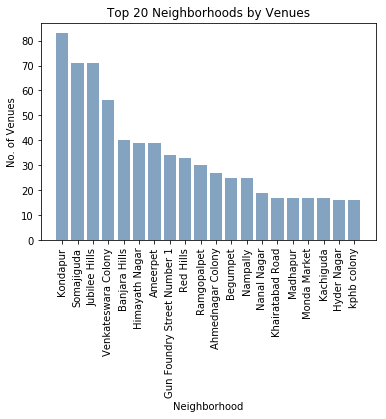

In [32]:
Top_20_Neighborhoods_data = Venues_count_by_Neighborhood.head(20)

plt.bar(Top_20_Neighborhoods_data.Neighbourhood,Top_20_Neighborhoods_data['Venue_Count'], align='center',color=(0.2, 0.4, 0.6, 0.6))
plt.title("Top 20 Neighborhoods by Venues")
plt.xlabel("Neighborhood")
plt.ylabel("No. of Venues")
plt.xticks(rotation=90)
plt.show()

### Top 10 Venue Categories

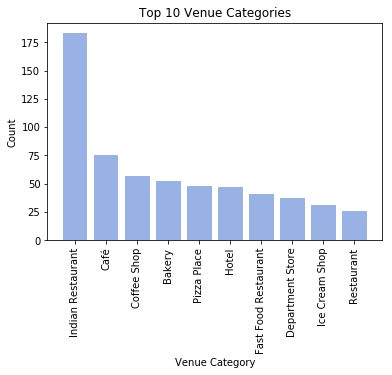

In [33]:
plt.bar(Venue_Categories_data['Venue_Category'],Venue_Categories_data['Count'], align='center',color=(0.2, 0.4, 0.8, 0.5))
plt.title("Top 10 Venue Categories")
plt.xlabel("Venue Category")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [34]:
print(Venues_data_complete['Venue Category'].nunique())
sorted(Venues_data_complete['Venue Category'].unique())[:5]

176


['ATM',
 'Afghan Restaurant',
 'American Restaurant',
 'Andhra Restaurant',
 'Arcade']

### Filtering Venues which stores or supermarkets only

In [36]:
Store_venues_filter = [venue for venue in Venues_data_complete['Venue Category'] if venue in ['Supermarket', 'Department Store', 'Convenience Store','Shopping Mall',
                       'Multiplex','Market','Farmers Market','Grocery Store','Fruit & Vegetable Store']]

Supermarket_Venues = Venues_data_complete[Venues_data_complete['Venue Category'].isin(Store_venues_filter)]
Supermarket_Venues.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 92 to 1344
Data columns (total 7 columns):
Neighbourhood              92 non-null object
Neighbourhood Latitude     92 non-null float64
Neighbourhood Longitude    92 non-null float64
Venue Name                 92 non-null object
Venue Latitude             92 non-null float64
Venue Longitude            92 non-null float64
Venue Category             92 non-null object
dtypes: float64(4), object(3)
memory usage: 5.8+ KB


In [37]:
Hyd_venues = Folium.Map(location=[latitude, longitude], zoom_start=11)

for lat,long,cat,name in zip(Supermarket_Venues['Venue Latitude'], Supermarket_Venues['Venue Longitude'],
                        Supermarket_Venues['Venue Category'],Supermarket_Venues['Venue Name']):
    Folium.CircleMarker(
        [lat,long],
        radius=5,
        popup=Folium.Popup("{},{}".format(name,cat), parse_html=True), #displays the popup for each point on map 
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6,
        parse_html=False).add_to(Hyd_venues)
Hyd_venues

### Neigborhoods with supermarket filter

In [38]:
Neighborhoods_with_markets = Supermarket_Venues[['Neighbourhood','Venue Category']].groupby(by=['Neighbourhood']).count().reset_index()
Neighborhoods_with_markets.columns = ['Neighbourhood','Count']
Neighborhoods_with_markets.sort_values(by=['Count'],ascending=False).reset_index(drop=True).head(5)

,Neighbourhood,Count
0,Somajiguda,4
1,Begumbazar,3
2,Venkateswara Colony,3
3,Gun Foundry Street Number 1,3
4,Shaikpet,3


### Choosing Neighborhoods for clustering 
Since there is high population and avg house price in west part of Hyderabad, for clustering we will consider <b>Neighborhoods in west Hyderabad.</b>

In [39]:
Neighborhoods_filter = ['Jubilee Hills','Yousufguda','Ameerpet','Madhapur','Kondapur','Gachibowli','Banjara Hills','Somajiguda','Shaikpet',
                        'Venkateswara Colony','Serilingampally','Miyapur','kphb colony']
Neighborhoods_West_Hyd = Venues_data_complete[Venues_data_complete.Neighbourhood.isin(Neighborhoods_filter)]
Neighborhoods_West_Hyd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434 entries, 17 to 914
Data columns (total 7 columns):
Neighbourhood              434 non-null object
Neighbourhood Latitude     434 non-null float64
Neighbourhood Longitude    434 non-null float64
Venue Name                 434 non-null object
Venue Latitude             434 non-null float64
Venue Longitude            434 non-null float64
Venue Category             434 non-null object
dtypes: float64(4), object(3)
memory usage: 27.1+ KB


In [40]:
Neighborhoods_West_Hyd['Venue Category'].nunique()

99

In [41]:
# one hot encoding
onehot = pd.get_dummies(Neighborhoods_West_Hyd[['Venue Category']], prefix="", prefix_sep="")

# Hyd_Boroughs_onehot['Postalcode'] = Venues['Postalcode'] 
# onehot['Borough'] = Venues['Borough']
onehot['Neighbourhood'] = Venues_data_complete['Neighbourhood'] 

# # move neighborhood column to the first column
fixed_columns = list(onehot.columns[-1:]) + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

print(onehot.shape)
onehot.head()

(434, 100)


,Neighbourhood,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,...,Stadium,Steakhouse,Supermarket,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Train Station,Vegetarian / Vegan Restaurant,Volleyball Court,Women's Store
17,Gachibowli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,Gachibowli,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
19,Gachibowli,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
20,Gachibowli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,Gachibowli,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
onehot_groupd = onehot.groupby(['Neighbourhood']).mean().reset_index()
print(onehot_groupd.shape)
onehot_groupd

(13, 100)


,Neighbourhood,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,...,Stadium,Steakhouse,Supermarket,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Train Station,Vegetarian / Vegan Restaurant,Volleyball Court,Women's Store
0,Ameerpet,0.000000,0.0000,0.000000,0.025641,0.000000,0.000000,0.000000,0.000000,0.051282,...,0.000000,0.000,0.025641,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000
1,Banjara Hills,0.000000,0.0000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.025000,...,0.000000,0.025,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.000000,0.000000
2,Gachibowli,0.000000,0.0000,0.000000,0.000000,0.090909,0.090909,0.000000,0.000000,0.000000,...,0.181818,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Jubilee Hills,0.000000,0.0000,0.000000,0.000000,0.014085,0.000000,0.000000,0.000000,0.028169,...,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085
4,Kondapur,0.012048,0.0000,0.012048,0.000000,0.036145,0.000000,0.012048,0.012048,0.012048,...,0.000000,0.000,0.000000,0.012048,0.000000,0.000000,0.000000,0.012048,0.012048,0.000000
5,Madhapur,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000
6,Miyapur,0.000000,0.0000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Serilingampally,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,...,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Shaikpet,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,...,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Somajiguda,0.000000,0.0000,0.000000,0.000000,0.014085,0.000000,0.000000,0.014085,0.014085,...,0.000000,0.000,0.000000,0.000000,0.014085,0.000000,0.000000,0.056338,0.000000,0.000000


#### Get 10 most common venue categories in each area

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
Columns = ['Neighbourhood']

freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
        
columns = Columns+freqColumns

# create a new dataframe
Top_Neighborhood_Venues = pd.DataFrame(columns=columns)
# Top_Neighborhood_Venues['Postalcode'] = Hyd_Boroughs_groupd['Postalcode']
# Top_Neighborhood_Venues['Borough'] = onehot_groupd['Borough']
Top_Neighborhood_Venues['Neighbourhood'] = onehot_groupd['Neighbourhood']

for ind in np.arange(onehot_groupd.shape[0]):
    row_categories = onehot_groupd.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    Top_Neighborhood_Venues.iloc[ind, 1:] = row_categories_sorted.index.values[0:num_top_venues]

Top_Neighborhood_Venues.sort_values(freqColumns, inplace=True)
Top_Neighborhood_Venues = Top_Neighborhood_Venues.reset_index(drop=True)

In [45]:
Top_Neighborhood_Venues.shape

(13, 11)

### Clustering Neighborhoods (Using K-Means Algorithm)

#### Determine optimal K value for k-means using elbow method

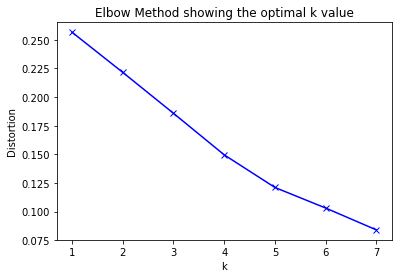

In [46]:
# clustering dataset
from sklearn import metrics
from scipy.spatial.distance import cdist

Hyd_Neighborhoods_Cluster = onehot_groupd.drop(['Neighbourhood'], axis=1)

# k means determine k
distortions = []
K = range(1,8)
for k in K:
    kmeans_model = KMeans(n_clusters=k).fit(Hyd_Neighborhoods_Cluster)
    kmeans_model.fit(Hyd_Neighborhoods_Cluster)
    distortions.append(sum(np.min(cdist(Hyd_Neighborhoods_Cluster, kmeans_model.cluster_centers_, 'euclidean'), axis=1)) / Hyd_Neighborhoods_Cluster.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method showing the optimal k value')
plt.show()

### Clustering with k=5

In [47]:
# set number of clusters
num_clusters = 5

Hyd_Neighborhoods_Cluster = onehot_groupd.drop(['Neighbourhood'], axis=1)

# k-means clustering
kmeans_model = KMeans(n_clusters=num_clusters, random_state=0).fit(Hyd_Neighborhoods_Cluster)

# check cluster labels generated
print(kmeans_model.labels_[:20])

# insert clustering labels in main dataframe
Top_Neighborhood_Venues.insert(1, 'Clusters', kmeans_model.labels_) 
Top_Neighborhood_Venues.head()

[0 0 4 0 0 0 3 2 1 0 0 0 0]


,Neighbourhood,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Serilingampally,0,Bakery,Pizza Place,Public Art,Ice Cream Shop,Fruit & Vegetable Store,Electronics Store,Concert Hall,Convenience Store,Cupcake Shop,Deli / Bodega
1,Venkateswara Colony,0,Coffee Shop,Hookah Bar,Café,Indian Restaurant,Department Store,Bakery,Hotel,Ice Cream Shop,Breakfast Spot,Restaurant
2,Gachibowli,4,Food Court,Stadium,Coffee Shop,Asian Restaurant,College Rec Center,Sandwich Place,Athletics & Sports,Hotel,Frozen Yogurt Shop,Gaming Cafe
3,Kondapur,0,Indian Restaurant,Café,Coffee Shop,Hotel,Pizza Place,Fast Food Restaurant,Italian Restaurant,Restaurant,Asian Restaurant,Sandwich Place
4,Jubilee Hills,0,Indian Restaurant,Café,Hookah Bar,Ice Cream Shop,Coffee Shop,Dessert Shop,Spa,Fast Food Restaurant,Bakery,Diner


#### Re-merging with Neighborhood Coordinates data

In [48]:
Hyd_Neighborhood_Merged = Neighborhoods_West_Hyd[['Neighbourhood','Neighbourhood Latitude','Neighbourhood Longitude']].join(Top_Neighborhood_Venues.set_index('Neighbourhood'), on='Neighbourhood')
Hyd_Neighborhood_Merged.drop_duplicates(subset = ['Neighbourhood','Neighbourhood Latitude','Neighbourhood Longitude'],inplace = True)
Hyd_Neighborhood_Merged.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Gachibowli,17.438649,78.346610,4,Food Court,Stadium,Coffee Shop,Asian Restaurant,College Rec Center,Sandwich Place,Athletics & Sports,Hotel,Frozen Yogurt Shop,Gaming Cafe
30,Jubilee Hills,17.426672,78.412085,0,Indian Restaurant,Café,Hookah Bar,Ice Cream Shop,Coffee Shop,Dessert Shop,Spa,Fast Food Restaurant,Bakery,Diner
185,Venkateswara Colony,17.422061,78.437652,0,Coffee Shop,Hookah Bar,Café,Indian Restaurant,Department Store,Bakery,Hotel,Ice Cream Shop,Breakfast Spot,Restaurant
241,Banjara Hills,17.410512,78.439913,0,Indian Restaurant,Coffee Shop,Café,Asian Restaurant,Italian Restaurant,Hotel,Sandwich Place,Gym,Hookah Bar,Hotel Bar
309,kphb colony,17.486765,78.383508,1,Indian Restaurant,Juice Bar,Fast Food Restaurant,Shopping Mall,Coffee Shop,Multiplex,Ice Cream Shop,Bakery,Rajasthani Restaurant,Burger Joint


### Visualising the Neighborhood clusters on Map

In [49]:
map_clusters = Folium.Map([latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, long, neighborhood, cluster in zip(Hyd_Neighborhood_Merged['Neighbourhood Latitude'], Hyd_Neighborhood_Merged['Neighbourhood Longitude'],
                                            Hyd_Neighborhood_Merged['Neighbourhood'], Hyd_Neighborhood_Merged['Clusters']):
    label = Folium.Popup(str(neighborhood) + ' Cluster: ' + str(cluster), parse_html=True)
    Folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

In [50]:
map_clusters = Folium.Map([latitude, longitude], zoom_start=12)
map_clusters.choropleth(
    geo_data=Hyd_geojson,data=Hyd_locality_data,
    columns=['Locality','Avg_Price'],key_on= 'properties.name',
    fill_color='YlOrRd', fill_opacity=0.5, line_opacity=0.3
    )

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, long, neighborhood, cluster in zip(Hyd_Neighborhood_Merged['Neighbourhood Latitude'], Hyd_Neighborhood_Merged['Neighbourhood Longitude'],
                                            Hyd_Neighborhood_Merged['Neighbourhood'], Hyd_Neighborhood_Merged['Clusters']):
    label = Folium.Popup(str(neighborhood) + ' Cluster: ' + str(cluster), parse_html=True)
    Folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.65).add_to(map_clusters)
       
map_clusters

## Results and Discussion <a name="results"></a>

The analysis shows that although there is a great number of venues in Hyderabad (~1400 venues for 145 Neighborhoods), which are concentrated in western & west-central Neighborhoods. 

I considered only western part of Hyderabad (13 Neighborhoods discussed above) for clustering since they have are highly populated and avg house prices are also high, indicating comparatively high income of inhabitants. Also west part of Hyderabad has large number of work centers and offices (Gachibowli/Kondapur Neighborhoods).

#### Some points:

1. Somajiguda, Banjara Hills have number of supermarkets, convenience stores and department stores.
2. Kondapur, Jubilee Hills & Venkateswara Colony (which is an extension of Banjara hills) also have high number of venues and high population.

As per the business problem discussed in Introduction section, we can recommend answers as follows:

1. <b>Western part of Hyderabad</b> would be suitable for opening of supermarket/Hypermarket due to reasons discussed above.
2. In the western part, Neighborhoods such as <b>Jubilee hills/Banjara Hills</b>, <b>Somajiguda & Kondapur</b> can be recommended to open supermarkets.

In summary section, one of my aim was also visualize the Average Prices for per square feet with choropleth style map.  In final section, I created choropleth map which also has the below information for each borough:

1. Cluster name,
2. Housing Sales Price (Avg_Price)  as Choropleth,


## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Hyderabad Neighborhoods close to center with low number of restaurants to aid stakeholders in narrowing down the search for optimal location for a setting supermarket. 
Clustering of the Neighborhoods in western Hyderabad was performed in order to create major zones of interest (containing greatest number of potential locations) to be used as starting points for final exploration by stakeholders.

Recommended areas should be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

Final decision on supermarket restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to population/work centers & markets), proximity to major roads, real estate prices, social and economic dynamics of every neighborhood etc.